In [ ]:
from google.colab import files
uploaded = files.upload()


Saving requirements.txt to requirements (1).txt


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
!pip install -r requirements.txt

In [ ]:
import warnings
import nltk
import pyLDAvis
import contractions
import pandas as pd
import re
import matplotlib.pyplot as plt
import unicodedata
from bs4 import BeautifulSoup
import spacy
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from google.colab import drive
import opendatasets as od
import plotly.express as px
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
from bertopic import BERTopic

# For coherence
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from tqdm import tqdm

# ===============================================================
# ⚙️ 2. ENVIRONMENT SETUP
# ---------------------------------------------------------------
# Downloads NLTK stopwords and lemmatization data,
# loads SpaCy model for NLP tasks,
# and mounts Google Drive (for file access in Colab).
# ===============================================================
warnings.filterwarnings("ignore", category=DeprecationWarning)

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r"datetime\.datetime\.utcnow\(\) is deprecated"
)


nltk.download("stopwords")
nltk.download("wordnet")
nlp = spacy.load("en_core_web_sm")

# Mount Google Drive (only required in Google Colab)
drive.mount('/content/drive')

# ===============================================================
# 📥 3. LOAD & EXPLORE DATA
# ---------------------------------------------------------------
# Downloads the TripAdvisor Hotel Reviews dataset from Kaggle
# and provides an initial look at review ratings distribution.
# ===============================================================
od.download("https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews")

# Load dataset
raw_data = pd.read_csv('/content/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
raw_data['Review'] = raw_data['Review'].str.replace('*', ' stars')
# Copy original data for processing
df = raw_data.copy()

/usr/local/lib/python3.12/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.12/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware

Mounted at /content/drive
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: babakrommel
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews


100%|██████████| 5.14M/5.14M [00:00<00:00, 831MB/s]

In [ ]:
# ===============================================================
# 🧹 4. TEXT CLEANING & PREPROCESSING
# ---------------------------------------------------------------
# Performs comprehensive text cleaning:
# - Remove emojis, HTML tags, URLs, and special symbols
# - Convert text to lowercase
# - Expand contractions like “can’t” → “cannot”
# - Remove punctuation, numbers, and extra spaces
# ===============================================================

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251" "+]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Some rows may be NaN — guard against that
df['Review'] = df['Review'].fillna('').astype(str)

df["Review"] = df["Review"].apply(remove_emoji)


def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

df["Review"] = df["Review"].apply(remove_html_tags)

df["Review"] = df["Review"].str.lower()

def remove_url(text):
    return re.sub(r'https?:\S*', '', text)

def remove_punctuation(text):
    import string
    return ''.join([c for c in text if c not in string.punctuation])

df["Review"] = df["Review"].replace(r'\s+', ' ', regex=True)
df["Review"] = df["Review"].str.replace('<br />', '')

                                              Review  Rating
0  nice hotel expensive parking get good deal sta...       4
1  nothing special charge diamond member hilton d...       2
2  nice room star experience hotel monaco seattle...       3
3  unique great stay wonderful time hotel monaco ...       5
4  great stay great stay go seahawk game awesome ...       5


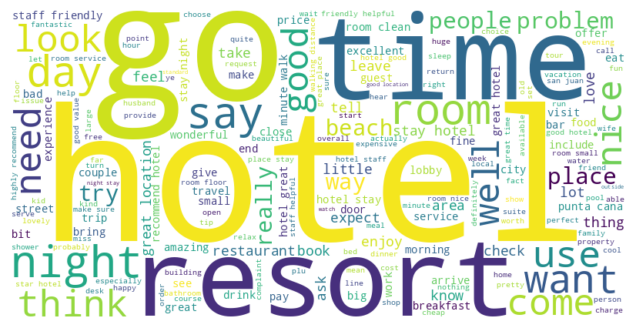

In [ ]:
# ===============================================================
# 🧽 5. TEXT NORMALIZATION, STOPWORD REMOVAL & LEMMATIZATION
# ---------------------------------------------------------------
# - Removes small and numeric tokens
# - Filters stopwords using NLTK list
# - Lemmatizes tokens using SpaCy (e.g., “running” → “run”)
# ===============================================================
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = contractions.fix(text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def remove_stopwords(text):
    return " ".join([w for w in text.split() if w.lower() not in stop_words])


def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Apply cleaning pipeline
df["Review"] = df["Review"].apply(clean_text).apply(remove_stopwords).apply(lemmatize)
print(df.head())

# WordCloud analyzes word frequency and creates a visual.
text = " ".join(df['Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# ===============================================================


In [ ]:
# ===============================================================
# 🔠 6. FEATURE EXTRACTION (TF-IDF VECTORIZATION)
# ---------------------------------------------------------------
# Converts text data into a numerical form using TF-IDF (Term Frequency–Inverse Document Frequency).
# This representation is ideal for algorithms like NMF and SVD
# because it emphasizes unique, informative words while reducing common ones.
# ===============================================================

tfidf_vectorizer = TfidfVectorizer(stop_words=list(spacy_stopwords), min_df=5, max_df=0.7)
tfidf_vectors = tfidf_vectorizer.fit_transform(df["Review"])

# Also prepare CountVectorizer for LDA
count_vectorizer = CountVectorizer(stop_words=list(spacy_stopwords), min_df=5, max_df=0.7)
count_vectors = count_vectorizer.fit_transform(df["Review"])

# ===============================================================
# ⚖️ COHERENCE SCORE SETUP
# ---------------------------------------------------------------
# We'll use Gensim's CoherenceModel to evaluate topic coherence.
# Prepare corpus and dictionary for coherence computation
# ===============================================================
texts = [doc.split() for doc in df["Review"]]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Helper: display topics (keeps your original function)
def display_topics(h, features, no_top_words=5):
    for topic, words in enumerate(h):
        largest = words.argsort()[::-1]
        print(f"\nTopic {topic}")
        for i in range(no_top_words):
            print("  %s" % (features[largest[i]]))



Topic 1
------------------------------
check                | Coefficient: 0.9995
tell                 | Coefficient: 0.9373
day                  | Coefficient: 0.9304
time                 | Coefficient: 0.8946
ask                  | Coefficient: 0.7971
desk                 | Coefficient: 0.7727
book                 | Coefficient: 0.7206
leave                | Coefficient: 0.6445
arrive               | Coefficient: 0.6331
bad                  | Coefficient: 0.6073

Topic 2
------------------------------
resort               | Coefficient: 1.6284
beach                | Coefficient: 1.3824
food                 | Coefficient: 0.7952
pool                 | Coefficient: 0.7696
beautiful            | Coefficient: 0.4776
vacation             | Coefficient: 0.4720
drink                | Coefficient: 0.4509
water                | Coefficient: 0.4437
people               | Coefficient: 0.4419
restaurant           | Coefficient: 0.4211

Topic 3
------------------------------
great               

NMF coherence: 100%|██████████| 46/46 [1:12:28<00:00, 94.54s/it] 


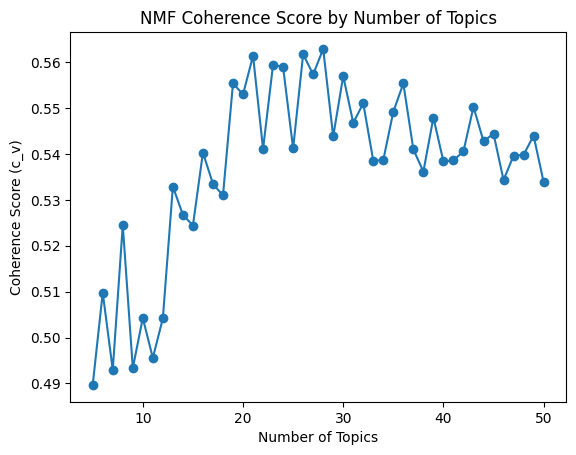

    n_topics  coherence
23        28   0.562885
21        26   0.561735
16        21   0.561392
18        23   0.559474
19        24   0.558904


In [ ]:
# ===============================================================
# 🧩 7. TOPIC MODELING - NMF (Non-negative Matrix Factorization)
# ---------------------------------------------------------------
# Keep original NMF flow and add coherence-based exploration
# ===============================================================


nmf = NMF(n_components=10, random_state=42, max_iter=600)
W_nmf = nmf.fit_transform(tfidf_vectors)
H_nmf = nmf.components_

def display_topics(h, features, no_top_words=10):
    for topic_idx, topic_weights in enumerate(h):
        print(f"\nTopic {topic_idx + 1}")
        print("-" * 30)
        top_indices = topic_weights.argsort()[::-1][:no_top_words]
        for i in top_indices:
            word = features[i]
            weight = topic_weights[i]
            print(f"{word:<20} | Coefficient: {weight:.4f}")

# Display topics with coefficients
display_topics(H_nmf, tfidf_vectorizer.get_feature_names_out(), no_top_words=10)



# --- Coherence sweep for NMF ---

def compute_coherence_nmf(start=5, stop=50, step=1):
    coherence_scores = []
    topic_range = list(range(start, stop + 1, step))
    for n_topics in tqdm(topic_range, desc='NMF coherence'):
        model_tmp = NMF(n_components=n_topics, random_state=42, max_iter=600)
        W = model_tmp.fit_transform(tfidf_vectors)
        H = model_tmp.components_
        topics = [
            [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            for topic in H
        ]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(cm.get_coherence())
    plt.plot(topic_range, coherence_scores, marker='o')
    plt.title("NMF Coherence Score by Number of Topics")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.show()
    return pd.DataFrame({'n_topics': topic_range, 'coherence': coherence_scores})

nmf_scores_df = compute_coherence_nmf(5, 50, 1)
print(nmf_scores_df.sort_values('coherence', ascending=False).head())




Topic 1
------------------------------
great                | Coefficient: 0.2145
good                 | Coefficient: 0.1962
nice                 | Coefficient: 0.1480
staff                | Coefficient: 0.1471
location             | Coefficient: 0.1406
night                | Coefficient: 0.1358
day                  | Coefficient: 0.1252
time                 | Coefficient: 0.1228
clean                | Coefficient: 0.1217
beach                | Coefficient: 0.1213

Topic 2
------------------------------
resort               | Coefficient: 0.3913
beach                | Coefficient: 0.3052
food                 | Coefficient: 0.1669
pool                 | Coefficient: 0.1653
people               | Coefficient: 0.1140
vacation             | Coefficient: 0.1130
drink                | Coefficient: 0.0991
cana                 | Coefficient: 0.0979
punta                | Coefficient: 0.0978
water                | Coefficient: 0.0973

Topic 3
------------------------------
great               

SVD coherence: 100%|██████████| 46/46 [20:20<00:00, 26.52s/it]


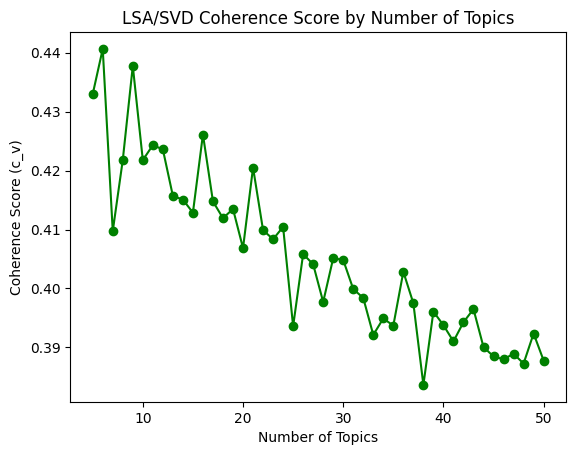

    n_topics  coherence
1          6   0.440654
4          9   0.437760
0          5   0.432982
11        16   0.426129
6         11   0.424322


In [ ]:
# ===============================================================
# 🧩 8. TOPIC MODELING - SVD (Latent Semantic Analysis / LSA)
# ---------------------------------------------------------------
# Keep original SVD flow and add coherence-based exploration
# ===============================================================


svd = TruncatedSVD(n_components=10, random_state=42)
W_svd = svd.fit_transform(tfidf_vectors)
H_svd = svd.components_

def display_topics_svd(h, features, no_top_words=10):
    for topic_idx, topic_weights in enumerate(h):
        print(f"\nTopic {topic_idx + 1}")
        print("-" * 30)
        top_indices = topic_weights.argsort()[::-1][:no_top_words]
        for i in top_indices:
            word = features[i]
            weight = topic_weights[i]
            print(f"{word:<20} | Coefficient: {weight:.4f}")

# Display SVD topics with coefficients
display_topics_svd(H_svd, tfidf_vectorizer.get_feature_names_out(), no_top_words=10)


# --- Coherence sweep for SVD/LSA ---

def compute_coherence_svd(start=5, stop=50, step=1):
    coherence_scores = []
    topic_range = list(range(start, stop + 1, step))
    for n_topics in tqdm(topic_range, desc='SVD coherence'):
        svd_tmp = TruncatedSVD(n_components=n_topics, random_state=42)
        W = svd_tmp.fit_transform(tfidf_vectors)
        H = svd_tmp.components_
        topics = [
            [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            for topic in H
        ]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(cm.get_coherence())
    plt.plot(topic_range, coherence_scores, marker='o', color='green')
    plt.title("LSA/SVD Coherence Score by Number of Topics")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.show()
    return pd.DataFrame({'n_topics': topic_range, 'coherence': coherence_scores})

svd_scores_df = compute_coherence_svd(5, 50, 1)
print(svd_scores_df.sort_values('coherence', ascending=False).head())


In [ ]:

# ===============================================================
# 🧩 9. TOPIC MODELING - LDA (Latent Dirichlet Allocation)
# ---------------------------------------------------------------
# Keep original LDA flow and add coherence-based exploration
# ===============================================================



lda = LatentDirichletAllocation(n_components=10, random_state=42, n_jobs=4)
lda.fit(count_vectors)

# ✅ Display top words with coefficients for each topic
def display_topics_lda(model, feature_names, no_top_words=10):
    for topic_idx, topic_weights in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}")
        print("-" * 30)
        top_indices = topic_weights.argsort()[::-1][:no_top_words]
        for i in top_indices:
            word = feature_names[i]
            weight = topic_weights[i]
            print(f"{word:<20} | Coefficient: {weight:.4f}")

display_topics_lda(lda, count_vectorizer.get_feature_names_out(), no_top_words=10)






Topic 1
------------------------------
good                 | Coefficient: 2154.8144
night                | Coefficient: 2077.9257
breakfast            | Coefficient: 1915.9890
bed                  | Coefficient: 1506.6221
bathroom             | Coefficient: 1476.6620
nice                 | Coefficient: 1476.4479
clean                | Coefficient: 1435.2912
like                 | Coefficient: 1299.4064
small                | Coefficient: 1205.3773
staff                | Coefficient: 1176.1562

Topic 2
------------------------------
beach                | Coefficient: 1789.1910
pool                 | Coefficient: 1250.3884
great                | Coefficient: 1036.3312
san                  | Coefficient: 967.8879
juan                 | Coefficient: 921.5741
view                 | Coefficient: 892.1493
restaurant           | Coefficient: 734.9010
nice                 | Coefficient: 693.6959
old                  | Coefficient: 629.1189
area                 | Coefficient: 609.9081

Topic 

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda.transform(count_vectors),
    doc_lengths=count_vectors.sum(axis=1).A1,
    vocab=count_vectorizer.get_feature_names_out(),
    term_frequency=count_vectors.sum(axis=0).A1
)

# If running in Jupyter/Colab this will render the visualization
vis




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.067376  0.130179       1        1  17.858424
7      0.156807  0.009926       2        1  14.243526
3     -0.098402 -0.053966       3        1  14.240043
5     -0.032438 -0.100087       4        1  10.885345
9     -0.155566 -0.005730       5        1   9.959513
0      0.065970 -0.121667       6        1   9.478190
2      0.048684 -0.094629       7        1   8.192215
8     -0.080030  0.081022       8        1   5.905315
4      0.057110  0.045191       9        1   5.063312
1     -0.029511  0.109760      10        1   4.174115, topic_info=           Term          Freq         Total Category  logprob  loglift
919       beach  10107.000000  10107.000000  Default  30.0000  30.0000
8284     resort   8967.000000   8967.000000  Default  29.0000  29.0000
7566       pool   8277.000000   8277.000000  Default  28.0000  28.0000
4371      great  21184.000000  21184.000000  Default  27.0000  27.0000
5759   location  11131.000000  11131.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
5676       like    350.476075   9225.235418  Topic10  -5.3051  -0.0941
10882      walk    342.095446   8875.084636  Topic10  -5.3293  -0.0796
10100      time    350.646117  12055.282221  Topic10  -5.3046  -0.3612
10332      trip    317.326279   5411.213792  Topic10  -5.4044   0.3400
9439      staff    312.018506  16304.187422  Topic10  -5.4213  -0.7798

[906 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
31         6  0.964511   acacia
40         1  0.037858   access
40         2  0.015380   access
40         3  0.258501   access
40         4  0.373258   access
...      ...       ...      ...
11245      3  0.986508  youbahn
11260     10  0.980783   yunque
11262      6  0.883562     ywca
11273      9  0.932787   zocalo
11274      9  0.976751     zona

[2991 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 4, 6, 10, 1, 3, 9, 5, 2])

LDA coherence: 100%|██████████| 46/46 [3:25:12<00:00, 267.65s/it]


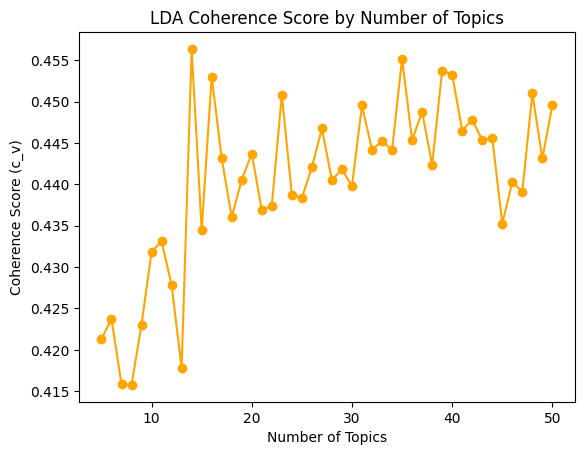

    n_topics  coherence
9         14   0.456354
30        35   0.455183
34        39   0.453727
35        40   0.453255
11        16   0.453013


In [ ]:
# --- Coherence sweep for LDA ---

def compute_coherence_lda(start=5, stop=50, step=1):
    coherence_scores = []
    topic_range = list(range(start, stop + 1, step))
    for n_topics in tqdm(topic_range, desc='LDA coherence'):
        lda_tmp = LatentDirichletAllocation(n_components=n_topics, random_state=42, n_jobs=-1)
        lda_tmp.fit(count_vectors)
        topics = [
            [count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            for topic in lda_tmp.components_
        ]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(cm.get_coherence())
    plt.plot(topic_range, coherence_scores, marker='o', color='orange')
    plt.title("LDA Coherence Score by Number of Topics")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.show()
    return pd.DataFrame({'n_topics': topic_range, 'coherence': coherence_scores})

lda_scores_df = compute_coherence_lda(5, 50, 1)
print(lda_scores_df.sort_values('coherence', ascending=False).head())

BERTopic coherence sweep (2–50):   0%|          | 0/49 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

BERTopic coherence sweep (2–50): 100%|██████████| 49/49 [7:46:29<00:00, 571.22s/it]


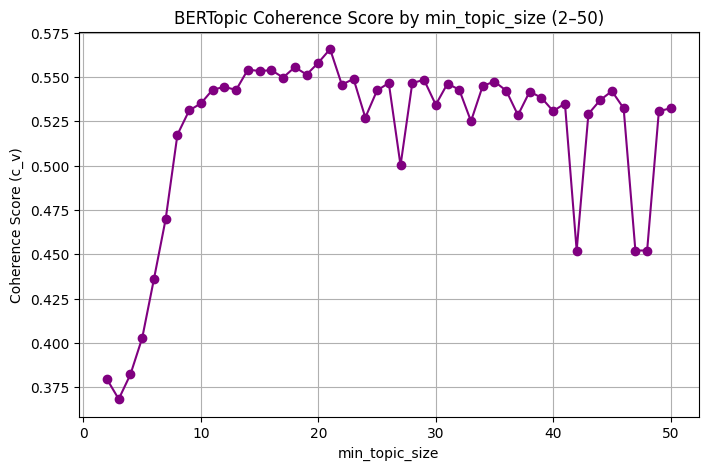

In [ ]:
# ===============================================================
# 🧠 10. TOPIC MODELING - BERTopic with Coherence Evaluation (2–50)
# ---------------------------------------------------------------
# We'll evaluate how coherence changes for different BERTopic
# configurations by varying `min_topic_size` from 2 to 50.
# ===============================================================
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from tqdm import tqdm
import matplotlib.pyplot as plt

# 🧹 Prepare tokenized texts and dictionary
texts = [str(doc).split() for doc in df["Review"]]  # simple whitespace tokenization
dictionary = Dictionary(texts)

# Define range of valid min_topic_size values (2–50)
min_topic_sizes = list(range(2, 51))
bertopic_scores = []

for size in tqdm(min_topic_sizes, desc="BERTopic coherence sweep (2–50)"):
    try:
        # Build and fit model
        model_tmp = BERTopic(
            verbose=False,
            embedding_model="paraphrase-MiniLM-L3-v2",
            min_topic_size=size
        )
        topics_tmp, _ = model_tmp.fit_transform(df["Review"])

        # Extract topic words
        freq_tmp = model_tmp.get_topic_info()
        topic_words = []
        for topic_id in freq_tmp["Topic"]:
            if topic_id == -1:
                continue
            words = [w for w, _ in model_tmp.get_topic(topic_id)]
            topic_words.append(words)

        # Compute coherence if topics are found
        if topic_words:
            cm = CoherenceModel(
                topics=topic_words,
                texts=texts,
                dictionary=dictionary,
                coherence="c_v"
            )
            coherence = cm.get_coherence()
            bertopic_scores.append(coherence)
        else:
            bertopic_scores.append(0)
    except Exception as e:
        print(f"⚠️ Skipped min_topic_size={size} due to error: {e}")
        bertopic_scores.append(0)

# 📈 Plot coherence vs. min_topic_size
plt.figure(figsize=(8, 5))
plt.plot(min_topic_sizes, bertopic_scores, marker='o', color='purple')
plt.title("BERTopic Coherence Score by min_topic_size (2–50)")
plt.xlabel("min_topic_size")
plt.ylabel("Coherence Score (c_v)")
plt.grid(True)
plt.show()

In [ ]:
# 🧾 Print best configuration
best_size = min_topic_sizes[bertopic_scores.index(max(bertopic_scores))]
print(f"\n🏆 Best min_topic_size = {best_size} with coherence = {max(bertopic_scores):.4f}")

# 🏁 Display the best configuration
best_idx = int(np.argmax(bertopic_scores))
best_size = min_topic_sizes[best_idx]
best_score = bertopic_scores[best_idx]
print(f"✅ Best BERTopic coherence: {best_score:.4f} (min_topic_size={best_size})")

# 🔁 Train a final BERTopic model using the best parameter


🏆 Best min_topic_size = 21 with coherence = 0.5657
✅ Best BERTopic coherence: 0.5657 (min_topic_size=21)


In [ ]:
# 🔁 Train a final BERTopic model using the best parameter
model_best = BERTopic(
    verbose=True,
    embedding_model="paraphrase-MiniLM-L3-v2",
    min_topic_size=best_size
)
topics_best, _ = model_best.fit_transform(df["Review"])

# Visualize and inspect


2025-10-23 05:19:20,246 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/641 [00:00<?, ?it/s]

2025-10-23 05:26:59,176 - BERTopic - Embedding - Completed ✓
2025-10-23 05:26:59,178 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-23 05:27:23,042 - BERTopic - Dimensionality - Completed ✓
2025-10-23 05:27:23,044 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-23 05:27:28,608 - BERTopic - Cluster - Completed ✓
2025-10-23 05:27:28,616 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-23 05:27:30,249 - BERTopic - Representation - Completed ✓


In [ ]:
# Get topic information
freq_best = model_best.get_topic_info()

# Exclude the outlier topic (-1)
real_topics = freq_best[freq_best['Topic'] != -1]

# Visualize all real topics in a bar chart
model_best.visualize_barchart(top_n_topics=len(real_topics))


In [ ]:
print(len(real_topics))

77


#Add new stop words from result of LDA

                                              Review  Rating
0  hotel expensive parking get deal stay hotel an...       4
1  nothing special charge diamond member hilton d...       2
2  room star experience hotel monaco seattle hote...       3
3  unique stay wonderful hotel monaco excellent s...       5
4  stay stay go seahawk game awesome downfall vie...       5


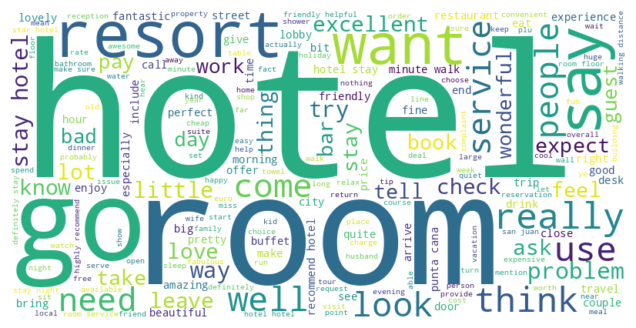

In [ ]:
# ===============================================================
# 🧽 11. TEXT NORMALIZATION, STOPWORD REMOVAL & LEMMATIZATION
# ---------------------------------------------------------------
# - Removes small and numeric tokens
# - Filters stopwords using NLTK list + custom LDA-based stopwords
# - Lemmatizes tokens using SpaCy (e.g., “running” → “run”)
# ===============================================================

# ✅ Base stopwords from NLTK
stop_words = set(stopwords.words("english"))

# ✅ Custom stopwords discovered via LDA
custom_stopwords_lda = [
    "good", "great", "nice", "time", "day", "like", "small", "place",
    "staff", "location", "clean", "breakfast", "pool", "beach",
    "food", "restaurant", "night", "area"
]

# ✅ Merge both lists
stop_words.update(custom_stopwords_lda)

# ---------------------------------------------------------------
# Cleaning, stopword removal, and lemmatization functions
# ---------------------------------------------------------------

def clean_text(text):
    text = contractions.fix(text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stopwords(text):
    return " ".join([w for w in text.split() if w.lower() not in stop_words])

def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# ---------------------------------------------------------------
# Apply cleaning pipeline to reviews
# ---------------------------------------------------------------
df["Review"] = df["Review"].apply(clean_text).apply(remove_stopwords).apply(lemmatize)
print(df.head())

# ---------------------------------------------------------------
# WordCloud: visualize most frequent remaining words
# ---------------------------------------------------------------
text = " ".join(df['Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# ===============================================================


#Updating vectorization according to new stopwords

In [ ]:
# ===============================================================
# 🔠 12. FEATURE EXTRACTION (TF-IDF VECTORIZATION)
# ---------------------------------------------------------------
# Converts text data into a numerical form using TF-IDF (Term Frequency–Inverse Document Frequency).
# This representation is ideal for algorithms like NMF and SVD
# because it emphasizes unique, informative words while reducing common ones.
# ===============================================================

tfidf_vectorizer = TfidfVectorizer(stop_words=list(spacy_stopwords), min_df=5, max_df=0.7)
tfidf_vectors = tfidf_vectorizer.fit_transform(df["Review"])

# Also prepare CountVectorizer for LDA
count_vectorizer = CountVectorizer(stop_words=list(spacy_stopwords), min_df=5, max_df=0.7)
count_vectors = count_vectorizer.fit_transform(df["Review"])

# ===============================================================
# ⚖️ COHERENCE SCORE SETUP
# ---------------------------------------------------------------
# We'll use Gensim's CoherenceModel to evaluate topic coherence.
# Prepare corpus and dictionary for coherence computation
# ===============================================================
texts = [doc.split() for doc in df["Review"]]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Helper: display topics (keeps your original function)
def display_topics(h, features, no_top_words=5):
    for topic, words in enumerate(h):
        largest = words.argsort()[::-1]
        print(f"\nTopic {topic}")
        for i in range(no_top_words):
            print("  %s" % (features[largest[i]]))

# new analysis LdA with attention that stopwords have been updated

In [ ]:
# ===============================================================
# 🧩 13. TOPIC MODELING - LDA (Latent Dirichlet Allocation)
# ---------------------------------------------------------------
# Keep original LDA flow and add coherence-based exploration
# ===============================================================



lda = LatentDirichletAllocation(n_components=10, random_state=42, n_jobs=4)
lda.fit(count_vectors)

# ✅ Display top words with coefficients for each topic
def display_topics_lda(model, feature_names, no_top_words=10):
    for topic_idx, topic_weights in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}")
        print("-" * 30)
        top_indices = topic_weights.argsort()[::-1][:no_top_words]
        for i in top_indices:
            word = feature_names[i]
            weight = topic_weights[i]
            print(f"{word:<20} | Coefficient: {weight:.4f}")

display_topics_lda(lda, count_vectorizer.get_feature_names_out(), no_top_words=10)



Topic 1
------------------------------
service              | Coefficient: 1919.1689
view                 | Coefficient: 1680.2109
excellent            | Coefficient: 1167.1673
price                | Coefficient: 948.1827
floor                | Coefficient: 947.7489
walk                 | Coefficient: 897.8889
star                 | Coefficient: 760.1279
bit                  | Coefficient: 731.1640
bathroom             | Coefficient: 709.6519
standard             | Coefficient: 708.4565

Topic 2
------------------------------
walk                 | Coefficient: 1726.6579
bathroom             | Coefficient: 1306.6656
street               | Coefficient: 1256.9064
paris                | Coefficient: 1236.9949
metro                | Coefficient: 1203.6600
barcelona            | Coefficient: 1029.2118
helpful              | Coefficient: 907.2131
minute               | Coefficient: 887.7409
friendly             | Coefficient: 843.3243
station              | Coefficient: 822.2912

Topic 3
--

#Show results graphically

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, None],
    doc_topic_dists=lda.transform(count_vectors),
    doc_lengths=count_vectors.sum(axis=1).A1,
    vocab=count_vectorizer.get_feature_names_out(),
    term_frequency=count_vectors.sum(axis=0).A1
)

# If running in Jupyter/Colab this will render the visualization
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.140867 -0.034911       1        1  19.480204
3     -0.119477  0.127881       2        1  13.754693
5      0.051019  0.065820       3        1  11.338568
0      0.067213  0.003907       4        1   9.474946
7     -0.131429 -0.127306       5        1   9.062822
6      0.134511 -0.060904       6        1   8.660365
1      0.108536  0.021006       7        1   7.968406
4     -0.025392  0.150561       8        1   7.447585
2     -0.032014 -0.104929       9        1   7.313968
8      0.087899 -0.041125      10        1   5.498444, topic_info=          Term         Freq         Total Category  logprob  loglift
8152    resort  8936.000000   8936.000000  Default  30.0000  30.0000
8487       san  1682.000000   1682.000000  Default  29.0000  29.0000
10691     walk  9040.000000   9040.000000  Default  28.0000  28.0000
4547   helpful  5443.000000   5443.000000  Default  27.0000  27.0000
1489       car  1982.000000   1982.000000  Default  26.0000  26.0000
...        ...          ...           ...      ...      ...      ...
6205    minute   421.335416   5481.877378  Topic10  -5.2605   0.3349
8720   service   426.885796  10666.546608  Topic10  -5.2474  -0.3176
8259     right   366.001411   4219.346580  Topic10  -5.4013   0.4559
724       away   361.201120   3928.607886  Topic10  -5.4145   0.5141
5449     large   354.865035   4307.812491  Topic10  -5.4322   0.4043

[883 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
5          3  0.121267         abc
5          5  0.020211         abc
5          8  0.848870         abc
34         7  0.017646   accademia
34        10  0.970511   accademia
...      ...       ...         ...
11047      6  0.944939     youbahn
11047      7  0.034571     youbahn
11061     10  0.989568      yunque
11064      6  0.968155  zandbergen
11074      6  0.946563        zona

[3094 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 6, 1, 8, 7, 2, 5, 3, 9])

# New coherence score for LDA

LDA coherence: 100%|██████████| 46/46 [2:37:39<00:00, 205.65s/it]


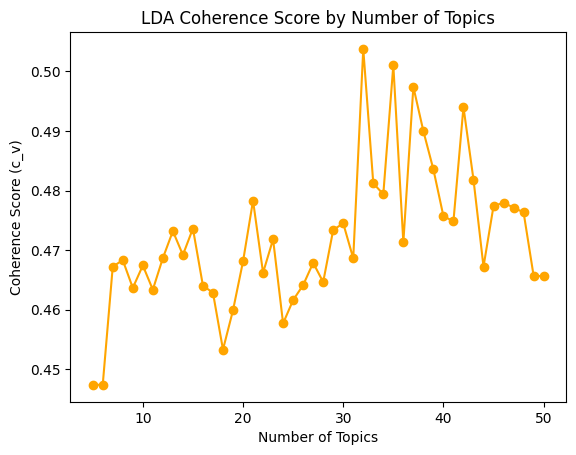

    n_topics  coherence
27        32   0.503790
30        35   0.501047
32        37   0.497418
37        42   0.494022
33        38   0.489973


In [ ]:
# --- Coherence sweep for LDA ---

def compute_coherence_lda(start=5, stop=50, step=1):
    coherence_scores = []
    topic_range = list(range(start, stop + 1, step))
    for n_topics in tqdm(topic_range, desc='LDA coherence'):
        lda_tmp = LatentDirichletAllocation(n_components=n_topics, random_state=42, n_jobs=-1)
        lda_tmp.fit(count_vectors)
        topics = [
            [count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            for topic in lda_tmp.components_
        ]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(cm.get_coherence())
    plt.plot(topic_range, coherence_scores, marker='o', color='orange')
    plt.title("LDA Coherence Score by Number of Topics")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.show()
    return pd.DataFrame({'n_topics': topic_range, 'coherence': coherence_scores})

lda_scores_df = compute_coherence_lda(5, 50, 1)
print(lda_scores_df.sort_values('coherence', ascending=False).head())

In [ ]:
lda = LatentDirichletAllocation(n_components=32, random_state=42, n_jobs=4)
lda.fit(count_vectors)

# ✅ Display top words with coefficients for each topic
def display_topics_lda(model, feature_names, no_top_words=32):
    for topic_idx, topic_weights in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}")
        print("-" * 30)
        top_indices = topic_weights.argsort()[::-1][:no_top_words]
        for i in top_indices:
            word = feature_names[i]
            weight = topic_weights[i]
            print(f"{word:<20} | Coefficient: {weight:.4f}")

display_topics_lda(lda, count_vectorizer.get_feature_names_out(), no_top_words=32)


Topic 1
------------------------------
service              | Coefficient: 1116.4492
view                 | Coefficient: 808.8419
business             | Coefficient: 647.0361
floor                | Coefficient: 496.5281
price                | Coefficient: 479.5878
standard             | Coefficient: 471.7745
excellent            | Coefficient: 441.5390
bar                  | Coefficient: 403.5115
star                 | Coefficient: 377.4986
bit                  | Coefficient: 371.8690
harbour              | Coefficient: 366.4725
rate                 | Coefficient: 361.4354
high                 | Coefficient: 344.7033
quality              | Coefficient: 328.3980
london               | Coefficient: 318.0825
pay                  | Coefficient: 315.0383
sydney               | Coefficient: 314.0040
large                | Coefficient: 294.7680
executive            | Coefficient: 283.0143
facility             | Coefficient: 278.3558
look                 | Coefficient: 265.3693
access        

# New Analysis with bertopic attention to editing list of stopwords

BERTopic coherence sweep (2–50):   0%|          | 0/49 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

BERTopic coherence sweep (2–50): 100%|██████████| 49/49 [7:55:09<00:00, 581.82s/it]


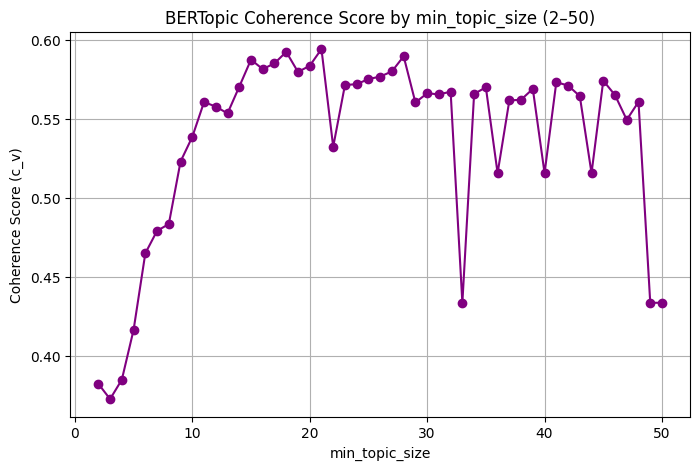

In [ ]:
# ===============================================================
# 🧠 14. TOPIC MODELING - BERTopic with Coherence Evaluation (2–50)
# ---------------------------------------------------------------
# We'll evaluate how coherence changes for different BERTopic
# configurations by varying `min_topic_size` from 2 to 50.
# ===============================================================
from bertopic import BERTopic
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from tqdm import tqdm
import matplotlib.pyplot as plt

# 🧹 Prepare tokenized texts and dictionary
texts = [str(doc).split() for doc in df["Review"]]  # simple whitespace tokenization
dictionary = Dictionary(texts)

# Define range of valid min_topic_size values (2–50)
min_topic_sizes = list(range(2, 51))
bertopic_scores = []

for size in tqdm(min_topic_sizes, desc="BERTopic coherence sweep (2–50)"):
    try:
        # Build and fit model
        model_tmp = BERTopic(
            verbose=False,
            embedding_model="paraphrase-MiniLM-L3-v2",
            min_topic_size=size
        )
        topics_tmp, _ = model_tmp.fit_transform(df["Review"])

        # Extract topic words
        freq_tmp = model_tmp.get_topic_info()
        topic_words = []
        for topic_id in freq_tmp["Topic"]:
            if topic_id == -1:
                continue
            words = [w for w, _ in model_tmp.get_topic(topic_id)]
            topic_words.append(words)

        # Compute coherence if topics are found
        if topic_words:
            cm = CoherenceModel(
                topics=topic_words,
                texts=texts,
                dictionary=dictionary,
                coherence="c_v"
            )
            coherence = cm.get_coherence()
            bertopic_scores.append(coherence)
        else:
            bertopic_scores.append(0)
    except Exception as e:
        print(f"⚠️ Skipped min_topic_size={size} due to error: {e}")
        bertopic_scores.append(0)

# 📈 Plot coherence vs. min_topic_size
plt.figure(figsize=(8, 5))
plt.plot(min_topic_sizes, bertopic_scores, marker='o', color='purple')
plt.title("BERTopic Coherence Score by min_topic_size (2–50)")
plt.xlabel("min_topic_size")
plt.ylabel("Coherence Score (c_v)")
plt.grid(True)
plt.show()

In [ ]:
# 🧾 Print best configuration
best_size = min_topic_sizes[bertopic_scores.index(max(bertopic_scores))]
print(f"\n🏆 Best min_topic_size = {best_size} with coherence = {max(bertopic_scores):.4f}")

# 🏁 Display the best configuration
best_idx = int(np.argmax(bertopic_scores))
best_size = min_topic_sizes[best_idx]
best_score = bertopic_scores[best_idx]
print(f"✅ Best BERTopic coherence: {best_score:.4f} (min_topic_size={best_size})")

# 🔁 Train a final BERTopic model using the best parameter


🏆 Best min_topic_size = 21 with coherence = 0.5940
✅ Best BERTopic coherence: 0.5940 (min_topic_size=21)


In [ ]:
# 🔁 Train a final BERTopic model using the best parameter
model_best = BERTopic(
    verbose=True,
    embedding_model="paraphrase-MiniLM-L3-v2",
    min_topic_size=best_size
)
topics_best, _ = model_best.fit_transform(df["Review"])

# Visualize and inspect

2025-10-28 04:38:49,000 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/641 [00:00<?, ?it/s]

2025-10-28 04:46:38,154 - BERTopic - Embedding - Completed ✓
2025-10-28 04:46:38,156 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-28 04:47:07,213 - BERTopic - Dimensionality - Completed ✓
2025-10-28 04:47:07,215 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-28 04:47:15,249 - BERTopic - Cluster - Completed ✓
2025-10-28 04:47:15,273 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-28 04:47:18,257 - BERTopic - Representation - Completed ✓


In [ ]:
# Get topic information
freq_best = model_best.get_topic_info()

# Exclude the outlier topic (-1)
real_topics = freq_best[freq_best['Topic'] != -1]

# Visualize all real topics in a bar chart
model_best.visualize_barchart(top_n_topics=len(real_topics))

# NEW NMF with attention to edited stopwords


Topic 1
------------------------------
bed                  | Coefficient: 1.8240
bathroom             | Coefficient: 1.2210
shower               | Coefficient: 0.9140
floor                | Coefficient: 0.7157
comfortable          | Coefficient: 0.7075
large                | Coefficient: 0.6758
noise                | Coefficient: 0.5886
size                 | Coefficient: 0.5482
window               | Coefficient: 0.5221
sleep                | Coefficient: 0.4851

Topic 2
------------------------------
resort               | Coefficient: 1.9402
people               | Coefficient: 0.5539
vacation             | Coefficient: 0.5433
drink                | Coefficient: 0.5178
beautiful            | Coefficient: 0.5153
water                | Coefficient: 0.4922
cana                 | Coefficient: 0.4644
punta                | Coefficient: 0.4634
buffet               | Coefficient: 0.4586
bar                  | Coefficient: 0.4066

Topic 3
------------------------------
wonderful           

NMF coherence: 100%|██████████| 46/46 [48:49<00:00, 63.68s/it] 


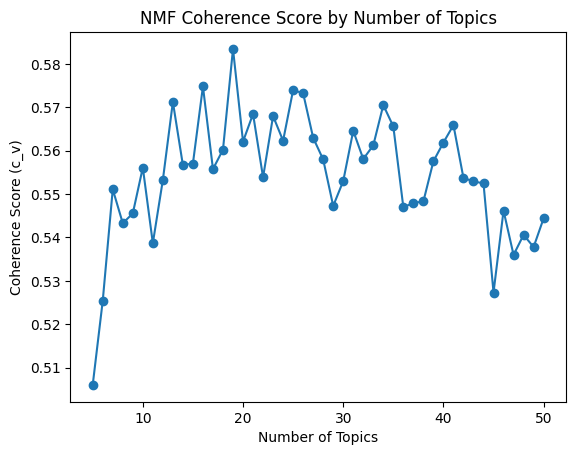

    n_topics  coherence
14        19   0.583434
11        16   0.574796
20        25   0.573956
21        26   0.573214
8         13   0.571216


In [ ]:
# ===============================================================
# 🧩 15. TOPIC MODELING - NMF (Non-negative Matrix Factorization)
# ---------------------------------------------------------------
# Keep original NMF flow and add coherence-based exploration
# ===============================================================


nmf = NMF(n_components=10, random_state=42, max_iter=600)
W_nmf = nmf.fit_transform(tfidf_vectors)
H_nmf = nmf.components_

def display_topics(h, features, no_top_words=10):
    for topic_idx, topic_weights in enumerate(h):
        print(f"\nTopic {topic_idx + 1}")
        print("-" * 30)
        top_indices = topic_weights.argsort()[::-1][:no_top_words]
        for i in top_indices:
            word = features[i]
            weight = topic_weights[i]
            print(f"{word:<20} | Coefficient: {weight:.4f}")

# Display topics with coefficients
display_topics(H_nmf, tfidf_vectorizer.get_feature_names_out(), no_top_words=10)



# --- Coherence sweep for NMF ---

def compute_coherence_nmf(start=5, stop=50, step=1):
    coherence_scores = []
    topic_range = list(range(start, stop + 1, step))
    for n_topics in tqdm(topic_range, desc='NMF coherence'):
        model_tmp = NMF(n_components=n_topics, random_state=42, max_iter=600)
        W = model_tmp.fit_transform(tfidf_vectors)
        H = model_tmp.components_
        topics = [
            [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            for topic in H
        ]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(cm.get_coherence())
    plt.plot(topic_range, coherence_scores, marker='o')
    plt.title("NMF Coherence Score by Number of Topics")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (c_v)")
    plt.show()
    return pd.DataFrame({'n_topics': topic_range, 'coherence': coherence_scores})

nmf_scores_df = compute_coherence_nmf(5, 50, 1)
print(nmf_scores_df.sort_values('coherence', ascending=False).head())

